### **We'd really appriciate an upvote. It is our first competition and we'd really motivates us to go on and do more projects. and we are open to all the suggestions and feedback from you all since we believe in learning from out mistakes. Thank You!**

## **Introduction**
Identifying harassment in social media discussions is vital, as is determining the number of unpleasant sentiments conveyed inside the comment. Organizations can save time and manual labor in regulating these platforms by automating this comment classification approach.The primary purpose is to determine the level of negativity and toxicity in internet comments. This could help to identify people who abuse individuals. As a result, it will eventually assist in the execution of policies and the penalty of individuals who do not obey, which can subsequently be used to reduce the level of toxicity in discussions. Using LSTM, CNN and FastText we aspire to build a multi-label classification model that separates comments into six groups according to their toxicity level: toxic, severe toxic, obscene, threat, insult, and identity-hate.

**We have used FastText word embedding to make the model more efficient even on the unseen data.**

# **Importing Libraries**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import csv
import pandas as pd
import random
import numpy as np
from keras import regularizers
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import itertools
from string import ascii_lowercase
from functools import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rounak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Importing Data**
The data that we have used for the model is Kaggle’s Toxic Comment Classification Dataset on Wikipedia’s Talk page edits.

In [2]:
train_path='C:\\Users\\Rounak\\Desktop\\OneDrive\\College\\Projects\\Severity-of-Toxic-Commentis-End-to-End\\artifacts\\data_ingestion\\train_data.csv'
train=pd.read_csv(train_path)

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0
1,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0
2,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0
3,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0
4,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0


In [4]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values  
print(y[:5])

[[1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


# **Data Visualization**

In [6]:
lens=train['comment_text'].str.len()

Text(0, 0.5, 'Number of Comments')

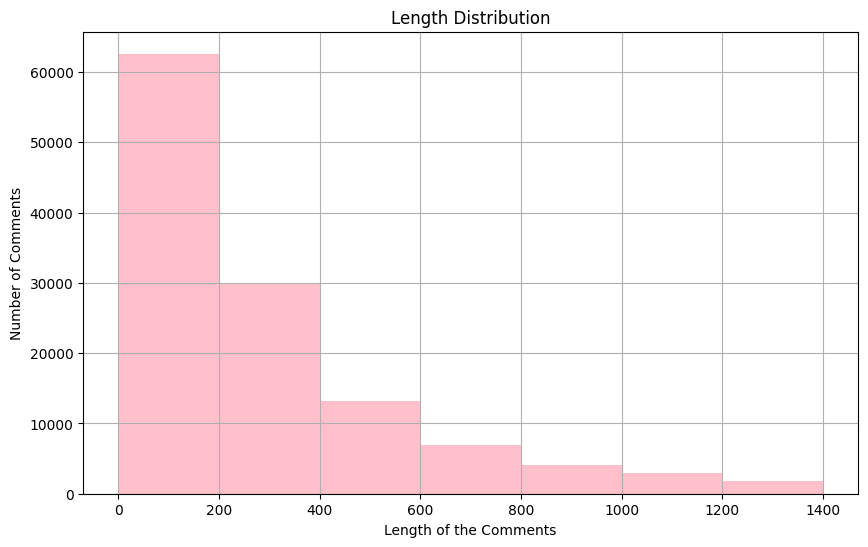

In [7]:
resize = np.arange(0, 1500,200)
lens.hist(color='pink', figsize=(10, 6), bins=resize,width=200 )
plt.title('Length Distribution')
plt.xlabel('Length of the Comments')
plt.ylabel('Number of Comments')

Maximum comment length are ranging from 0 to 200

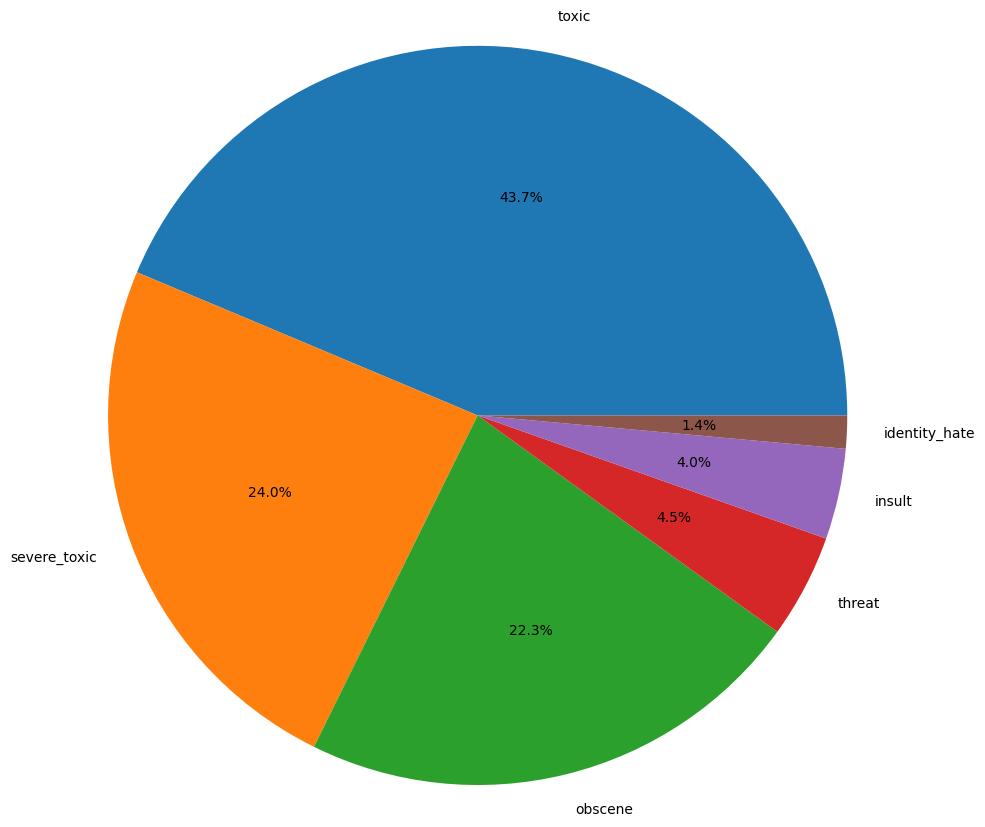

In [8]:
class_cnt = {}
for label in labels:
    class_cnt[label] = len(train[train[label] == 1])
    
class_cnt = {k: v for k, v in sorted(class_cnt.items(), key = lambda item: item[1], reverse = True)}
values=[*class_cnt.values()]
plt.pie(values, labels=labels, radius=2.5,autopct='%1.1f%%')
plt.show()

Number of toxic comments in the dataset are significantly higher. Identity Hate comments, on the other hand, are the lowest.

# **Data Pre-Processing**



In [9]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck','fuk', 'wtf','fucck','f cking'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$'
                                                           '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'
        ],

    ' asshole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'ass hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h','beetch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' transgender':
        [
            'transgender','trans gender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k','diick '
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bullshit ':
        [
            'bullsh\*t', 'bull\$hit','bs'
        ],

    ' homosexual':
        [
            'homo sexual','homosex'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots', 'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'
        ],

    ' shithole ':
        [
            'shythole','shit hole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumbass':
        [
            'dumb ass', 'dubass'
        ],

    ' asshead':
        [
            'butthead', 'ass head'
        ],

    ' sex ':
        [
            's3x', 'sexuality',
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' motherfucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker', 'mother fucker'
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
}

In [10]:
##Text Normalization

def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

In [11]:
train_texts = [] 
for line in train['comment_text']: 
    train_texts.append(clean_text(line))

In [12]:
##Lemmatization

lemmatizer= WordNetLemmatizer()
def lemma(text, lemmatization=True):
  output=''
  if lemmatization:
    text=text.split(' ')
    for word in text:
      word1 = lemmatizer.lemmatize(word, pos = "n") #noun 
      word2 = lemmatizer.lemmatize(word1, pos = "v") #verb
      word3 = lemmatizer.lemmatize(word2, pos = "a") #adjective
      word4 = lemmatizer.lemmatize(word3, pos = "r") #adverb
      output=output + " " + word4
  else:
    output=text
  
  return str(output.strip())

In [13]:
lema_train_text=[]
for line in train_texts:
    lema_train_text.append(lemma(line))

In [14]:
##Stopwords Removal

stopword_list=[]
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')


for letter in dual_alpha_list:
    stopword_list.append(letter)

In [15]:
print(stopword_list)
print(len(stopword_list))
print(len(lema_train_text))

['b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak', 'al', 'ao', 'ap', 'aq', 'ar', 'au', 'av', 'aw', 'ax', 'ay', 'az', 'ba', 'bb', 'bc', 'bd', 'bf', 'bg', 'bh', 'bi', 'bj', 'bk', 'bl', 'bm', 'bn', 'bo', 'bp', 'bq', 'br', 'bs', 'bt', 'bu', 'bv', 'bw', 'bx', 'bz', 'ca', 'cb', 'cc', 'cd', 'ce', 'cf', 'cg', 'ch', 'ci', 'cj', 'ck', 'cl', 'cm', 'cn', 'co', 'cp', 'cq', 'cr', 'cs', 'ct', 'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'da', 'db', 'dc', 'dd', 'de', 'df', 'dg', 'dh', 'di', 'dj', 'dk', 'dl', 'dm', 'dn', 'dp', 'dq', 'dr', 'ds', 'dt', 'du', 'dv', 'dw', 'dx', 'dy', 'dz', 'ea', 'eb', 'ec', 'ed', 'ee', 'ef', 'eg', 'eh', 'ei', 'ej', 'ek', 'el', 'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'eu', 'ev', 'ew', 'ex', 'ey', 'ez', 'fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fh', 'fi', 'fj', 'fk', 'fl', 'fm', 'fn', 'fo', 'fp', 'fq', 'fr', 'fs', 'ft', 'fu', 'fv', 'fw', 'fx

In [ ]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data
  return str(output.strip())

potential_stopwords = []
for line in tqdm_notebook(lema_train_text, total=159571): 
    potential_stopwords.append(search_stopwords(line))
print(len(potential_stopwords))

def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)



In [ ]:
#Looking for common terms in all top 50 dataframes.
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))
print(common_potential_stopwords)

In [16]:
#Retaining certain words and removing others from the above list.
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

#Adding above retrived words into the stopwords list.
for word in potential_stopwords:
    stopword_list.append(word)

In [17]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())

#Removing Stopwords from Train Data
processed_train_data = [] 
for line in lema_train_text: 
    processed_train_data.append(remove_stopwords(line))

In [20]:
temp_list = processed_train_data

In [19]:
max_features=148844
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

In [36]:
#Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)

In [37]:
len(processed_train_data)

127656

In [ ]:
#Indexing
word_index=tokenizer.word_index
print(len(word_index))

In [ ]:
#padding
training_padded=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')

In [ ]:
print('Tokenized sentences: \n', training_padded[10])
print('One hot label: \n', y[10])

In [ ]:
#Splitting data into Training and Validation Set

x_train, x_val, y_train, y_val = train_test_split(training_padded, y, test_size=0.2, random_state=2)

In [ ]:
print('Number of entries in each category: ')
print('Training: ', y_train.sum(axis=0))
print('Validation: ', y_val.sum(axis=0))

In [ ]:
embeddings_index_fasttext = {}
f = open('../input/popular-embedding/wiki-news-300d-1M/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    line.encode('utf-8').strip()
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector

# **LSTM**

In [ ]:
model_1 = tf.keras.Sequential([
	tf.keras.layers.Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings'),
  tf.keras.layers.Input(shape=(maxpadlen, ),dtype='int32'),
  tf.keras.layers.LSTM(40,return_sequences=True, name='lstm_layer'),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(.1),
  tf.keras.layers.Dense(30, activation='relu', kernel_initializer='he_uniform'),
	tf.keras.layers.Dropout(.1),
	tf.keras.layers.Dense(6, activation='sigmoid', kernel_initializer='glorot_uniform')
])
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

In [ ]:
history_1 = model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

# **Plotting Graph for LSTM**

In [ ]:
def plot_graphs(history_1, string):
  plt.plot(history_1.history[string])
  plt.plot(history_1.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_1, 'accuracy')
plot_graphs(history_1, 'loss')

# **LSTM-CNN Model**

In [ ]:
model_2 = tf.keras.Sequential([
	tf.keras.layers.Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings'),
  tf.keras.layers.Input(shape=(maxpadlen, ),dtype='int32'),
  tf.keras.layers.LSTM(50,return_sequences=True, name='lstm_layer'),
  tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.MaxPooling1D(3),
  tf.keras.layers.GlobalMaxPool1D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(40, activation="relu", kernel_initializer='he_uniform'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu", kernel_initializer='he_uniform'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')
])
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

In [ ]:
history_2 = model_2.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

# **Plotting Graph for LSTM-CNN**

In [ ]:
def plot_graphs(history_2, string):
  plt.plot(history_2.history[string])
  plt.plot(history_2.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_2, 'accuracy')
plot_graphs(history_2, 'loss')

# **Submission**

In [ ]:
sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

In [ ]:
c=0
clean=[]
for i in sub['text']:
  i=clean_text(i)
  i=lemma(i)
  i=remove_stopwords(i)
  clean.append(i)

In [ ]:
sub['Cleaned_Comments']=clean

In [ ]:
sub.head()

In [ ]:
X_ = tokenizer.texts_to_sequences(sub['Cleaned_Comments'])
test_padded = pad_sequences(X_, maxlen=maxpadlen, truncating='post')
pred = model_1.predict(test_padded)

In [ ]:
sub['score']=0.0

In [ ]:
for i in range(len(pred)):
    sub['score'][i]=pred[i][0]+pred[i][1]+pred[i][2]+pred[i][3]+pred[i][4]+pred[i][5]

In [ ]:
sub.head()

In [ ]:
for i in range(len(pred)):
  if sub['score'][i]>1:
    sub['score'][i]=1

In [ ]:
sub.drop(['text'],axis=1,inplace=True)
sub.drop(['Cleaned_Comments'],axis=1,inplace=True)

In [ ]:
sub.head()

In [ ]:
sub[['comment_id', 'score']].to_csv("submission.csv", index=False)

**You can check out our github for in depth understanding of our project. Link in our profile.**